<a href="https://colab.research.google.com/github/taehyeon4/CS5875_Final_Project/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

train_dataset_path = '/content/drive/My Drive/AML_Final_Project/training_data/ASL_Alphabet_Dataset/MiniData125'
test_dataset_path = '/content/drive/My Drive/AML_Final_Project/training_data/ASL_Alphabet_Dataset/asl_alphabet_test'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
import os

In [33]:
class SignLanguageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, letter_folder in enumerate(sorted(os.listdir(root_dir))):
            letter_path = os.path.join(root_dir, letter_folder)
            if os.path.isdir(letter_path):
                for img_name in os.listdir(letter_path):
                    img_path = os.path.join(letter_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)  # Assign a numeric label (0-25 for A-Z), (26 for del), (27 for nothing), (28 for space)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("L")  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [34]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 224x224 pixels for ResNet-18
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale images
])

In [35]:
train_dataset = SignLanguageDataset(root_dir=train_dataset_path, transform=transform)
test_dataset = SignLanguageDataset(root_dir=test_dataset_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
def CustomResNet18(num_classes=29):
    # Load ResNet-18 with pre-trained ImageNet weights
    model = models.resnet18(pretrained=True)

    # Modify the first layer to accept grayscale (1-channel) images with a smaller kernel
    model.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2, bias=False)

    # Modify the final fully connected layer to output the desired number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [37]:
# ## NOT IN USE ANYMORE

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
#         self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 29)  # 26 output classes for A-Z, 3 extra at the end

#     def forward(self, x):
#         x = torch.relu(self.conv1(x))
#         x = torch.max_pool2d(x, 2)
#         x = torch.relu(self.conv2(x))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 5 * 5)
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [39]:
from tqdm import tqdm

def train_model(model, loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Loop through batches with tqdm progress bar
        for images, labels in tqdm(loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()          # Clear gradients
            outputs = model(images)        # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()                # Backward pass
            optimizer.step()               # Update weights

            running_loss += loss.item()    # Accumulate batch loss

        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(loader):.4f}")


In [40]:
def evaluate_model(model, loader):
    model.eval()  # Set the model to evaluation mode (disables dropout, batchnorm)
    correct = 0
    total = 0

    # Disable gradient calculation for evaluation to save memory and speed up
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class with max probability

            total += labels.size(0)  # Count the total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    # Calculate and print accuracy
    print(f'Accuracy: {100 * correct / total:.2f}%')


In [41]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [42]:
model = CustomResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
evaluate_model(model, test_loader)

Epoch [1/10]: 100%|██████████| 116/116 [00:25<00:00,  4.47it/s]


Epoch [1/10], Training Loss: 1.7614


Epoch [2/10]: 100%|██████████| 116/116 [00:26<00:00,  4.35it/s]


Epoch [2/10], Training Loss: 0.7413


Epoch [3/10]: 100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Epoch [3/10], Training Loss: 0.5121


Epoch [4/10]: 100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Epoch [4/10], Training Loss: 0.3391


Epoch [5/10]: 100%|██████████| 116/116 [00:25<00:00,  4.48it/s]


Epoch [5/10], Training Loss: 0.2701


Epoch [6/10]: 100%|██████████| 116/116 [00:25<00:00,  4.57it/s]


Epoch [6/10], Training Loss: 0.2030


Epoch [7/10]: 100%|██████████| 116/116 [00:25<00:00,  4.55it/s]


Epoch [7/10], Training Loss: 0.1192


Epoch [8/10]: 100%|██████████| 116/116 [00:25<00:00,  4.62it/s]


Epoch [8/10], Training Loss: 0.1257


Epoch [9/10]: 100%|██████████| 116/116 [00:25<00:00,  4.61it/s]


Epoch [9/10], Training Loss: 0.1534


Epoch [10/10]: 100%|██████████| 116/116 [00:25<00:00,  4.59it/s]

Epoch [10/10], Training Loss: 0.1093


ZeroDivisionError: division by zero

In [44]:
torch.save(model.state_dict(), "sign_language_model.pth")

In [45]:
reverse_mapping = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F',
    6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L',
    12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R',
    18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X',
    24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'
}

<ipython-input-46-27d05f67e258>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sign_language_model.pth"))


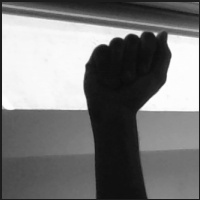

Predicted letter: A


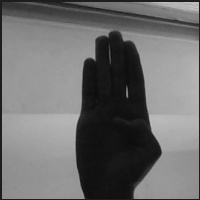

Predicted letter: B


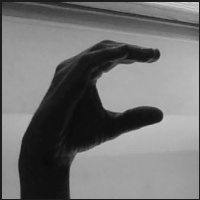

Predicted letter: C


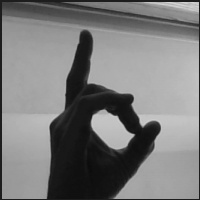

Predicted letter: D


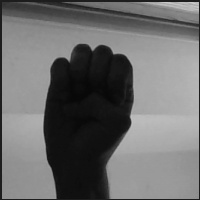

Predicted letter: E


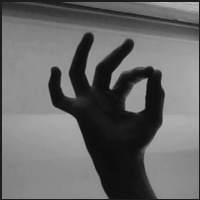

Predicted letter: F


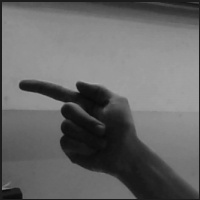

Predicted letter: G


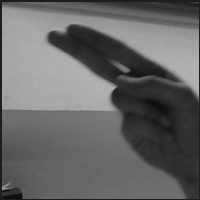

Predicted letter: H


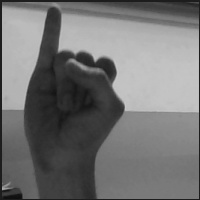

Predicted letter: I


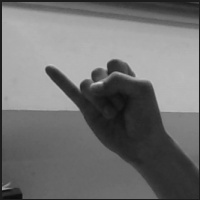

Predicted letter: J


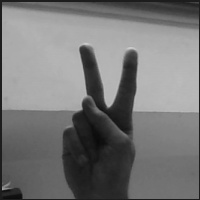

Predicted letter: K


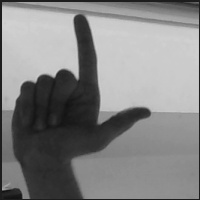

Predicted letter: L


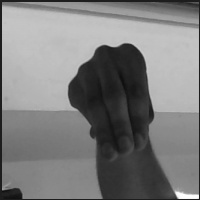

Predicted letter: M


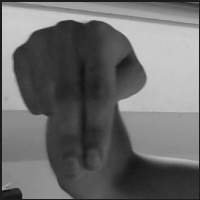

Predicted letter: N


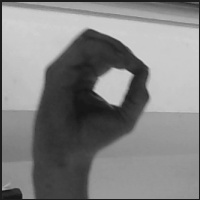

Predicted letter: O


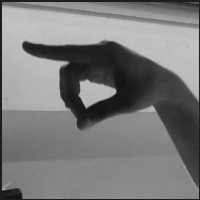

Predicted letter: P


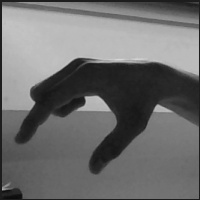

Predicted letter: Q


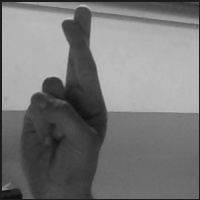

Predicted letter: R


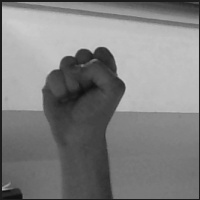

Predicted letter: S


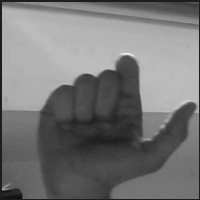

Predicted letter: T


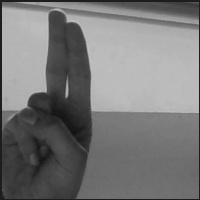

Predicted letter: U


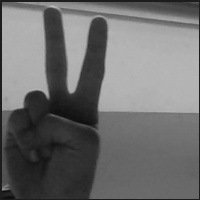

Predicted letter: V


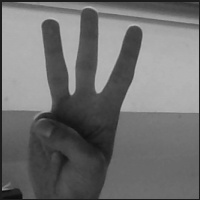

Predicted letter: W


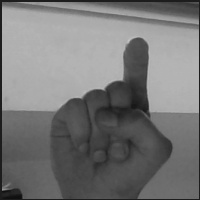

Predicted letter: X


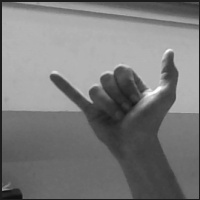

Predicted letter: Y


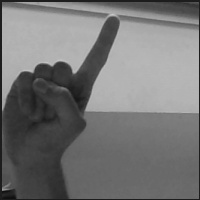

Predicted letter: Z


In [46]:
def predict(model, image_path):
    model.eval()
    image = Image.open(image_path).convert("L")
    display(image)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    output = model(image)
    _, predicted = torch.max(output, 1)
    return reverse_mapping[predicted.item()]  # Convert label to letter

# Example usage
model.load_state_dict(torch.load("sign_language_model.pth"))

for i in range(26):
    letter = predict(model, f"{test_dataset_path}/{chr(i + ord('A'))}_test.jpg")
    print("Predicted letter:", letter)